## Load in needed packages:

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
from IPython.core.display import display, HTML    # make sure Jupyter knows to display it as HTML
import time, os
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import unicodedata
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
from scipy import stats
from sklearn.linear_model import LinearRegression
import seaborn as sns

## Load in DF w/ new stats and do some initial exploring:

In [2]:
new_stats_df = pd.read_pickle("./new_stats.pkl")

In [3]:
new_stats_df.head()

Player    Year   Age     PA      G  Avg EV (MPH)  Avg LA (°)  \
0   Astudillo, Willians  2019.0  28.0  204.0   58.0          85.9        15.4   
1           Revere, Ben  2015.0  27.0  634.0  152.0          83.1         5.0   
2           Holt, Brock  2016.0  28.0  324.0   94.0          86.0         6.3   
3        Murphy, Daniel  2015.0  30.0  538.0  130.0          89.9        11.9   
4        Iglesias, Jose  2015.0  25.0  454.0  120.0          83.8         4.6   

   Barrel%  Solid Contact %  Flare/Burner %  ...  Straight Away %  Oppo %  \
0      2.7              5.4            28.0  ...             37.1    23.7   
1      0.0              2.1            30.0  ...             41.2    24.4   
2      2.5              4.7            28.8  ...             34.7    30.1   
3      4.9              6.2            25.3  ...             35.1    27.6   
4      0.0              1.3            24.0  ...             38.8    28.2   

   First Strike %   GB%   FB%  LD %  Sprint Speed              Player Link  \
0            64.7  40.3  21.0  29.0          24.2  [/savant-player/553902]   
1            56.6  57.1  14.6  26.9          28.4  [/savant-player/519184]   
2            58.6  55.1  14.0  25.8          28.2  [/savant-player/571788]   
3            57.2  43.3  23.6  25.7          25.7  [/savant-player/502517]   
4            63.4  59.1  11.6  21.9          28.4  [/savant-player/578428]   

            Player_Year_ID   wRC+  
0  Willians Astudillo-2019   76.0  
1          Ben Revere-2015   98.0  
2          Brock Holt-2016   87.0  
3       Daniel Murphy-2015  109.0  
4       Jose Iglesias-2015   97.0  

[5 rows x 28 columns]

In [4]:
new_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1893 entries, 0 to 1892
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               1893 non-null   object 
 1   Year                 1893 non-null   float64
 2   Age                  1893 non-null   float64
 3   PA                   1893 non-null   float64
 4   G                    1893 non-null   float64
 5   Avg EV (MPH)         1893 non-null   float64
 6   Avg LA (°)           1893 non-null   float64
 7   Barrel%              1893 non-null   float64
 8   Solid Contact %      1893 non-null   float64
 9   Flare/Burner %       1893 non-null   float64
 10  Under %              1893 non-null   float64
 11  Topped %             1893 non-null   float64
 12  Poor/Weak %          1893 non-null   float64
 13  Hard Hit %           1893 non-null   float64
 14  Zone Swing %         1893 non-null   float64
 15  Out of Zone Swing %  1893 non-null   f

In [5]:
new_stats_df.describe()

Year          Age           PA            G  Avg EV (MPH)  \
count  1893.000000  1893.000000  1893.000000  1893.000000   1893.000000   
mean   2017.206022    28.826730   435.196513   114.937137     88.413312   
std       1.557844     3.816009   155.619031    32.113398      2.215767   
min    2015.000000    20.000000   200.000000    46.000000     80.200000   
25%    2016.000000    26.000000   284.000000    89.000000     87.000000   
50%    2017.000000    28.000000   432.000000   119.000000     88.500000   
75%    2019.000000    32.000000   570.000000   144.000000     89.900000   
max    2020.000000    44.000000   747.000000   162.000000     96.100000   

        Avg LA (°)      Barrel%  Solid Contact %  Flare/Burner %      Under %  \
count  1893.000000  1893.000000      1893.000000     1893.000000  1893.000000   
mean     12.229688     6.797834         5.770100       24.733967    24.506233   
std       4.386683     4.020786         2.023787        3.418355     5.394669   
min      -1.400000     0.000000         0.000000       13.700000     6.800000   
25%       9.300000     3.700000         4.400000       22.400000    21.000000   
50%      12.300000     6.300000         5.800000       24.600000    24.400000   
75%      15.300000     9.300000         7.200000       27.100000    28.100000   
max      29.700000    25.700000        18.000000       37.500000    43.700000   

       ...  In Zone Contact %       Pull %  Straight Away %       Oppo %  \
count  ...        1893.000000  1893.000000      1893.000000  1893.000000   
mean   ...          83.313418    37.029900        37.787480    25.182831   
std    ...           5.529379     5.844259         3.847019     4.225243   
min    ...          62.400000    16.700000        25.900000    13.400000   
25%    ...          79.700000    33.400000        35.300000    22.300000   
50%    ...          83.700000    37.000000        37.800000    25.100000   
75%    ...          87.300000    40.900000        40.400000    27.900000   
max    ...          96.800000    56.800000        53.800000    43.400000   

       First Strike %          GB%          FB%         LD %  Sprint Speed  \
count     1893.000000  1893.000000  1893.000000  1893.000000   1893.000000   
mean        60.317591    44.516587    22.432224    25.902800     27.015742   
std          3.862401     6.949041     5.208745     3.629189      1.454924   
min         48.200000    20.100000     8.500000    14.900000     21.900000   
25%         57.500000    39.600000    18.700000    23.500000     26.100000   
50%         60.400000    44.400000    22.200000    25.700000     27.100000   
75%         63.000000    49.300000    26.000000    28.200000     28.100000   
max         71.800000    72.000000    43.500000    40.400000     30.800000   

              wRC+  
count  1893.000000  
mean    101.157422  
std      26.002898  
min       0.000000  
25%      84.000000  
50%     101.000000  
75%     118.000000  
max     197.000000  

[8 rows x 25 columns]

## Initial Visualization:

In [6]:
new_stats_df.corr()

Year       Age        PA         G  Avg EV (MPH)  \
Year                 1.000000 -0.050360 -0.177433 -0.259925      0.090235   
Age                 -0.050360  1.000000  0.007203  0.039772     -0.013654   
PA                  -0.177433  0.007203  1.000000  0.914547      0.201251   
G                   -0.259925  0.039772  0.914547  1.000000      0.090639   
Avg EV (MPH)         0.090235 -0.013654  0.201251  0.090639      1.000000   
Avg LA (°)           0.145444  0.044688  0.054227  0.024089      0.098858   
Barrel%              0.217394 -0.059126  0.119729  0.024670      0.734754   
Solid Contact %      0.146280  0.053587  0.128354  0.055503      0.568639   
Flare/Burner %      -0.030644  0.090726  0.061389  0.045961     -0.123826   
Under %              0.121762  0.063061 -0.016960 -0.016838     -0.162233   
Topped %            -0.167264 -0.044611 -0.077883 -0.022371     -0.215600   
Poor/Weak %          0.072251 -0.042927 -0.157334 -0.135637     -0.480797   
Hard Hit %           0.190818 -0.013957  0.152829  0.037690      0.924395   
Zone Swing %         0.105675 -0.105471  0.033756  0.035700      0.078073   
Out of Zone Swing % -0.035602 -0.125381  0.029977  0.052812     -0.100522   
In Zone Contact %   -0.144282  0.160117  0.171441  0.145494     -0.331503   
Pull %               0.063524  0.044283  0.020088 -0.005901      0.158695   
Straight Away %     -0.051559 -0.019327  0.034291  0.054583     -0.031002   
Oppo %              -0.040768 -0.043534 -0.059823 -0.042227     -0.191750   
First Strike %      -0.008403 -0.136230 -0.131613 -0.086561     -0.231957   
GB%                 -0.163909 -0.058724 -0.093918 -0.043170     -0.198094   
FB%                  0.208470  0.053814  0.124765  0.088417      0.278015   
LD %                -0.038431  0.047267  0.043566 -0.016867      0.083149   
Sprint Speed         0.046489 -0.462905  0.027853  0.026060     -0.171607   
wRC+                 0.075645 -0.043366  0.348204  0.187745      0.524570   

                     Avg LA (°)   Barrel%  Solid Contact %  Flare/Burner %  \
Year                   0.145444  0.217394         0.146280       -0.030644   
Age                    0.044688 -0.059126         0.053587        0.090726   
PA                     0.054227  0.119729         0.128354        0.061389   
G                      0.024089  0.024670         0.055503        0.045961   
Avg EV (MPH)           0.098858  0.734754         0.568639       -0.123826   
Avg LA (°)             1.000000  0.379588         0.344416       -0.177802   
Barrel%                0.379588  1.000000         0.515741       -0.356145   
Solid Contact %        0.344416  0.515741         1.000000       -0.171548   
Flare/Burner %        -0.177802 -0.356145        -0.171548        1.000000   
Under %                0.861879  0.033631         0.077258       -0.259401   
Topped %              -0.908696 -0.493094        -0.468443        0.019883   
Poor/Weak %           -0.070112 -0.118060        -0.158465       -0.118144   
Hard Hit %             0.128029  0.788451         0.635636       -0.134771   
Zone Swing %           0.090601  0.180358         0.095977       -0.080607   
Out of Zone Swing %   -0.052752 -0.079713        -0.130652       -0.020733   
In Zone Contact %     -0.194248 -0.574186        -0.309481        0.356073   
Pull %                 0.584696  0.337267         0.268004       -0.269271   
Straight Away %       -0.488535 -0.173592        -0.140813        0.094178   
Oppo %                -0.364187 -0.308958        -0.242689        0.286357   
First Strike %        -0.153201 -0.211050        -0.190906        0.023035   
GB%                   -0.935818 -0.443605        -0.449282        0.080040   
FB%                    0.815476  0.542669         0.467358       -0.278496   
LD %                   0.089665  0.025316         0.196527        0.550572   
Sprint Speed          -0.149793 -0.130303        -0.196761       -0.060447   
wRC+                   0.160165  0.545957         0.383263        0.0704

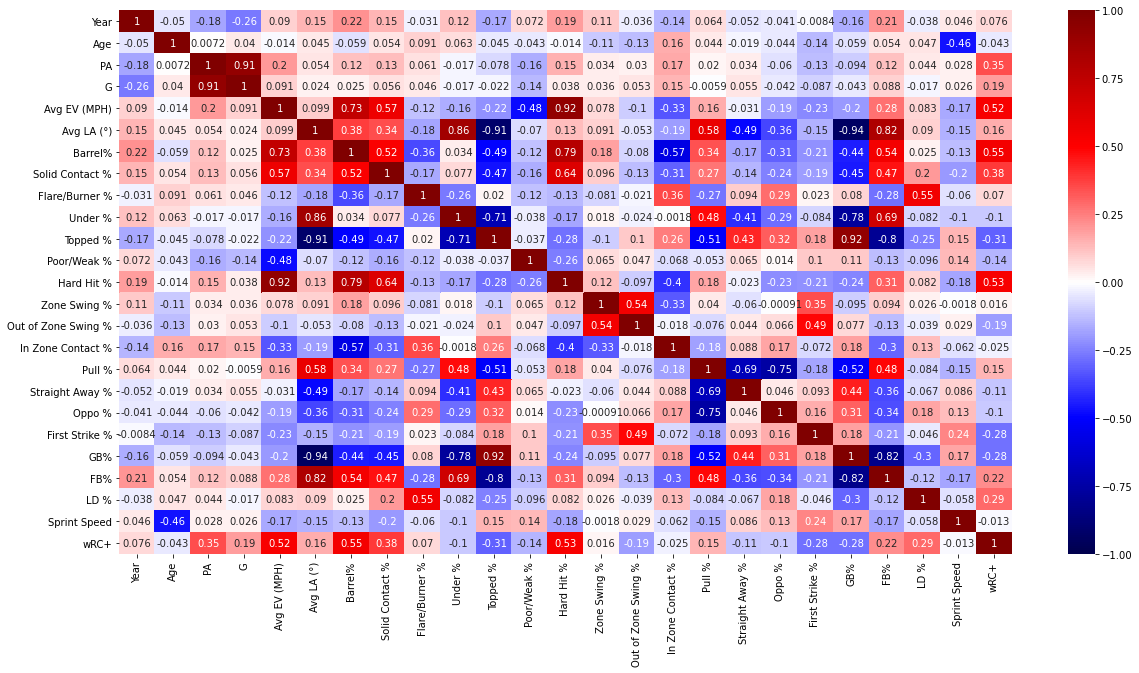

In [7]:
sns.heatmap(new_stats_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);

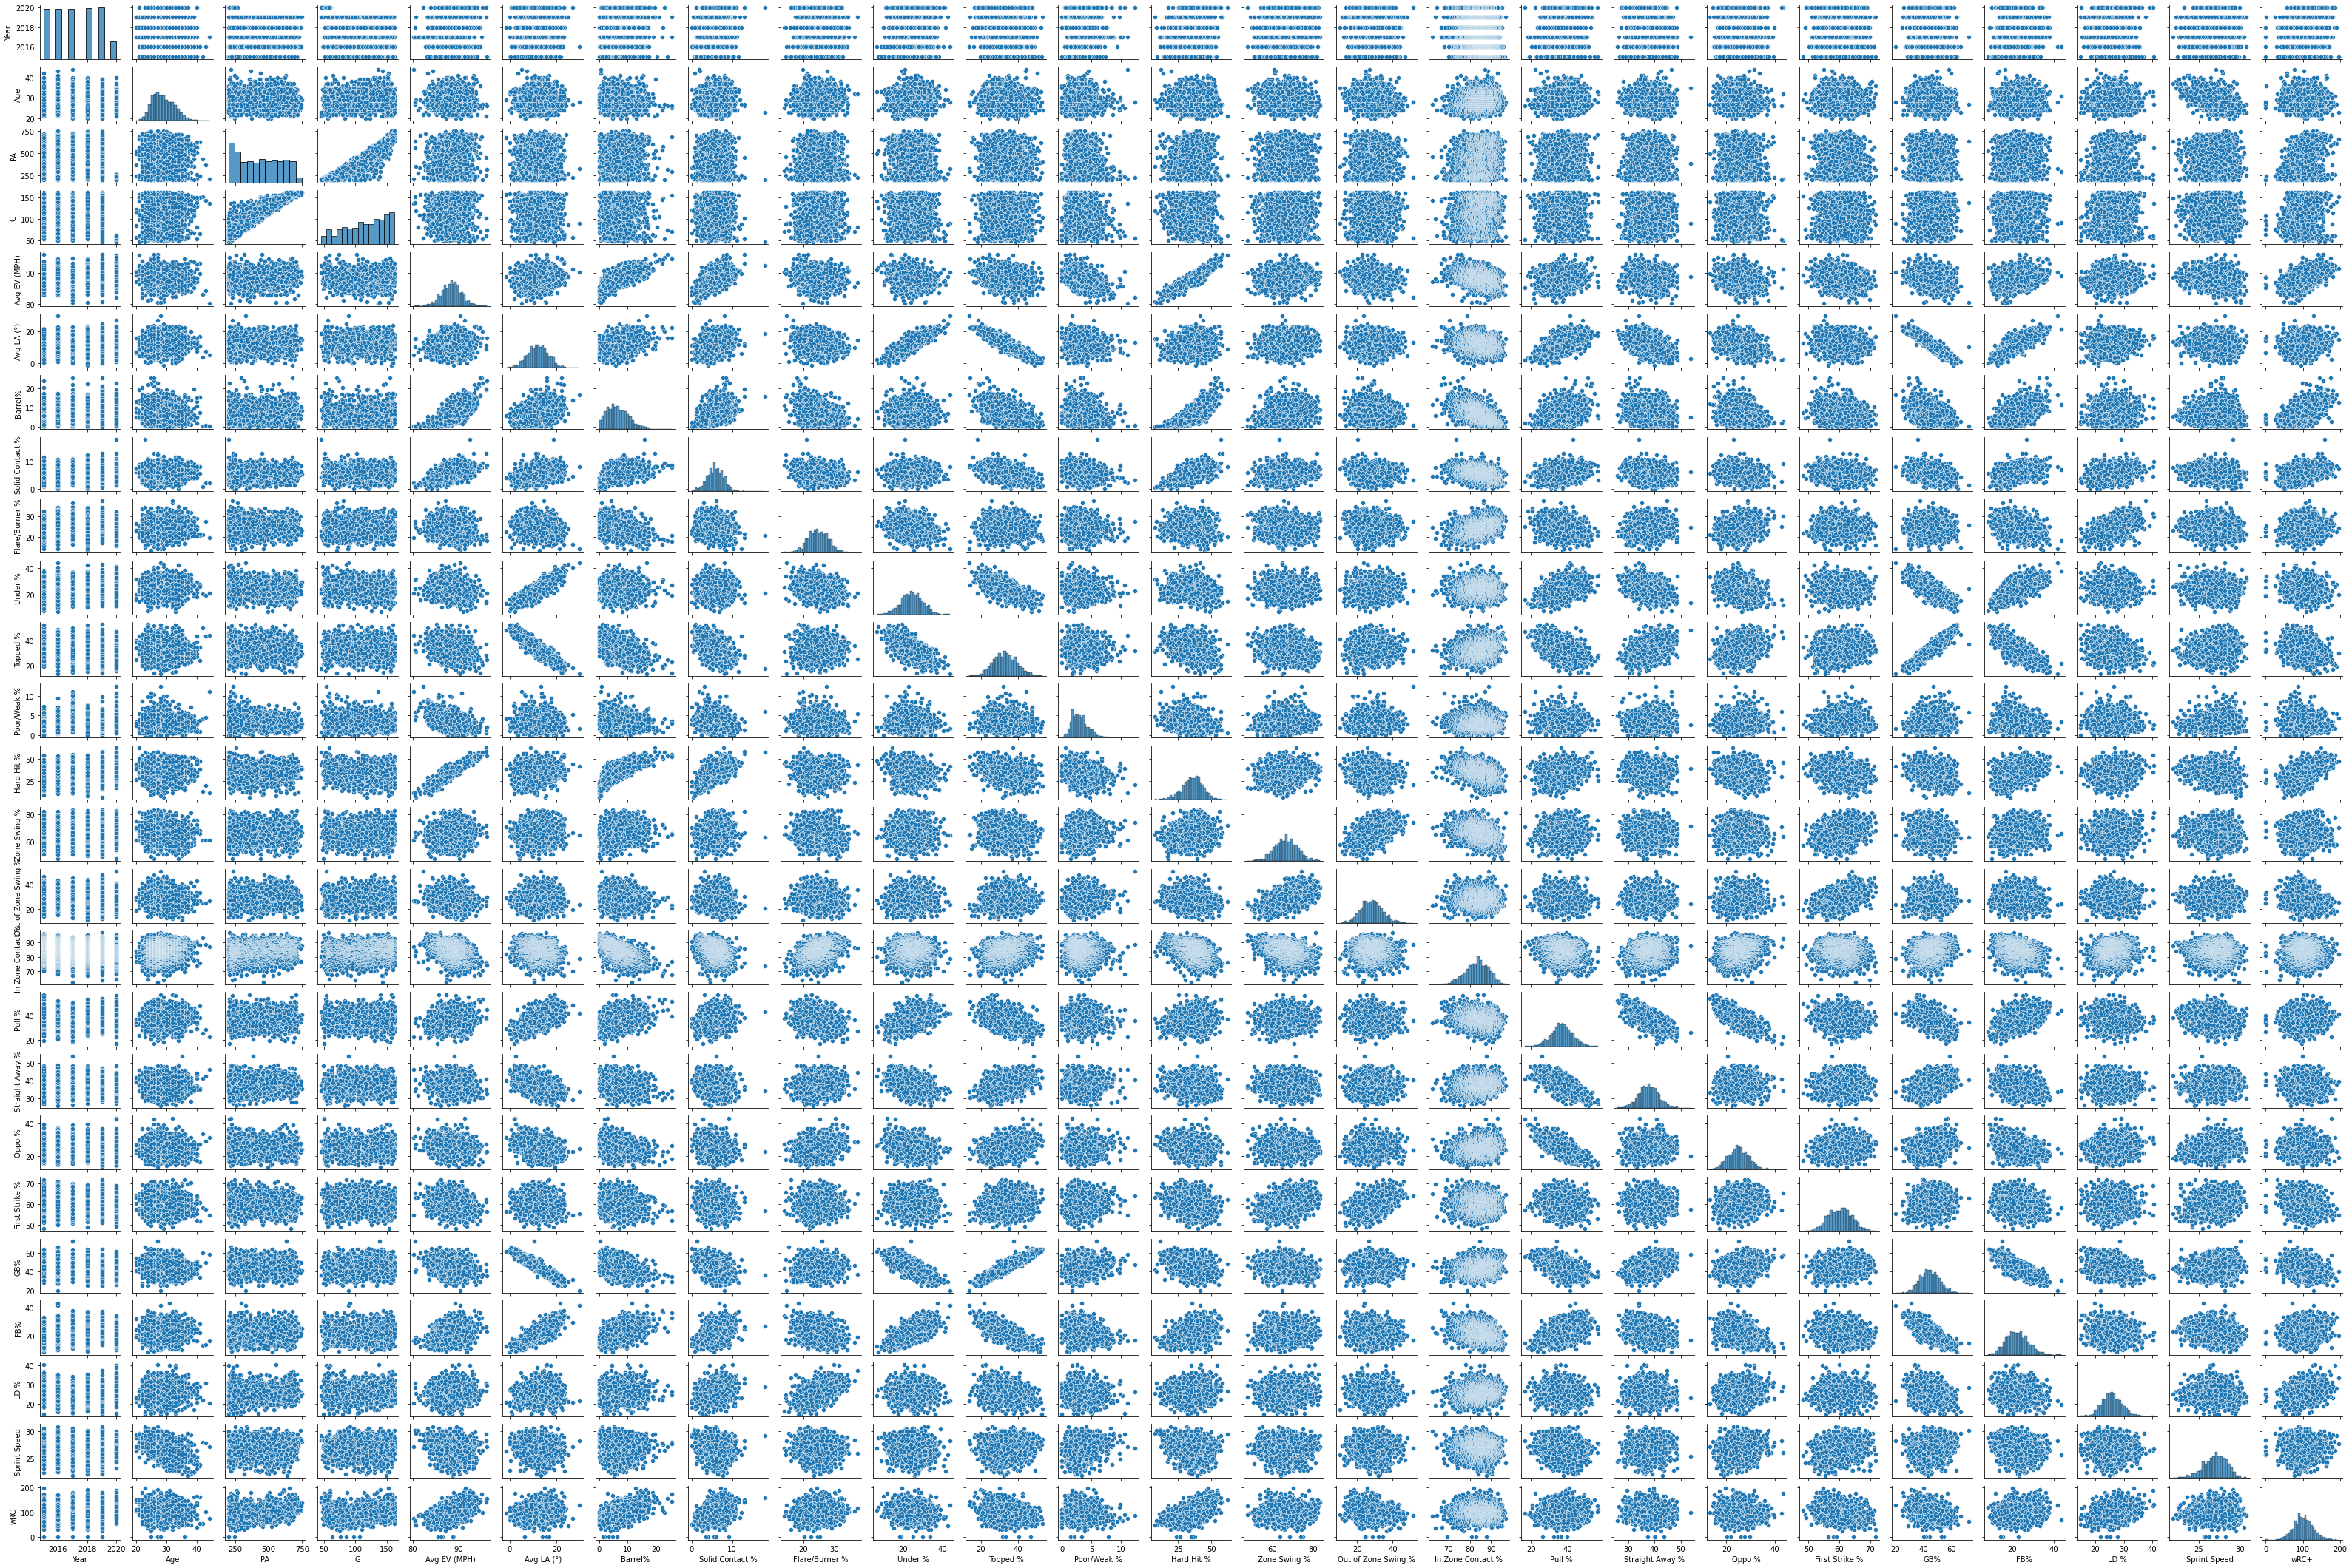

In [8]:
sns.pairplot(new_stats_df, height=1.2, aspect=1.5);

## Preprocessing/Splitting for Testing:

In [9]:
columns = ['Age','Avg EV (MPH)','Avg LA (°)','Barrel%','Solid Contact %',
          'Flare/Burner %','Under %','Topped %','Poor/Weak %','Hard Hit %',
          'Zone Swing %', 'Out of Zone Swing %','In Zone Contact %','Pull %',
          'Straight Away %', 'Oppo %', 'First Strike %','GB%','FB%','LD %',
          'Sprint Speed']

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [11]:
X,y = new_stats_df[columns], new_stats_df['wRC+']

SPlitting into train/val and test sets:

In [12]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=5)

## No Cross Validation:

Dividing train/val sets into individual sets:

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=12)

### Simple Linear Regression:

In [14]:
lm = LinearRegression()

In [15]:
lm.fit(X_train, y_train)
print(f'Simple Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

Simple Linear Regression val R^2: 0.542


In [16]:
list(zip(columns, lm.coef_))

[('Age', -0.21310102600398453),
 ('Avg EV (MPH)', 3.002180859924287),
 ('Avg LA (°)', -1.5867458249207766),
 ('Barrel%', 4.092024387166889),
 ('Solid Contact %', 1.5699668759355427),
 ('Flare/Burner %', 1.1449153026926322),
 ('Under %', -0.8709253841179823),
 ('Topped %', -0.6146182059068199),
 ('Poor/Weak %', 0.7260156618057618),
 ('Hard Hit %', -0.5895212968041403),
 ('Zone Swing %', 0.554306795955767),
 ('Out of Zone Swing %', -0.6009679104012805),
 ('In Zone Contact %', 2.0315663388132665),
 ('Pull %', -2.484224475015045),
 ('Straight Away %', -2.8640893025379914),
 ('Oppo %', -2.3157571225731512),
 ('First Strike %', -0.4949949555142275),
 ('GB%', -1.59883023893115),
 ('FB%', -0.8652267346728655),
 ('LD %', -0.5674935160806714),
 ('Sprint Speed', 2.5213641808203295)]

### Polynomial Regression (degrees 2-4):

In [18]:
#From Degree 2 to 6
degrees = [2,3,4]
for n in degrees:
    poly = PolynomialFeatures(degree=n) 

    X_train_poly = poly.fit_transform(X_train.values)
    X_val_poly = poly.transform(X_val.values)
    X_test_poly = poly.transform(X_test.values)

    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    print(f'Degree polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Degree polynomial regression val R^2: -0.332
Degree polynomial regression val R^2: -9.797
Degree polynomial regression val R^2: -6.095


Worse than simple linear.

In [30]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

## With Cross Validation:

In [19]:
from sklearn.model_selection import KFold

In [20]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=5)

In [21]:
X, y = np.array(X), np.array(y)

### Simple Linear, and Poly using KFOLD:

In [29]:
kf = KFold(n_splits=5, shuffle=True, random_state = 12)
cv_lm_r2s, cv_lm_poly_2 = [], [] #collect the validation results for both models

for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val))
    
    #2 Degree Polynomial:
    poly = PolynomialFeatures(degree=2) 

    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    lm_poly = LinearRegression()
    lm_poly.fit(X_train_poly, y_train)
    
    cv_lm_poly_2.append(lm_poly.score(X_val_poly, y_val))

print('Simple regression scores: ', cv_lm_r2s, '\n')
print('Poly (2) scores: ', cv_lm_poly_2, '\n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Poly (2) mean cv r^2: {np.mean(cv_lm_poly_2):.3f} +- {np.std(cv_lm_poly_2):.3f}')

Simple regression scores:  [0.5119718226716521, 0.5384501235118551, 0.5303596090099272, 0.5845485913331288, 0.48164670816793376] 

Poly (2) scores:  [0.3351223055830258, 0.26151184591508436, 0.4264579542207154, 0.44155420256418776, 0.24364605327680877] 

Simple mean cv r^2: 0.529 +- 0.034
Poly (2) mean cv r^2: 0.342 +- 0.082


### Lasso:

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [46]:
columns

['Age',
 'Avg EV (MPH)',
 'Avg LA (°)',
 'Barrel%',
 'Solid Contact %',
 'Flare/Burner %',
 'Under %',
 'Topped %',
 'Poor/Weak %',
 'Hard Hit %',
 'Zone Swing %',
 'Out of Zone Swing %',
 'In Zone Contact %',
 'Pull %',
 'Straight Away %',
 'Oppo %',
 'First Strike %',
 'GB%',
 'FB%',
 'LD %',
 'Sprint Speed']

In [50]:
X = new_stats_df[columns]
y = new_stats_df['wRC+']

In [51]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=5)

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=12)

In [53]:
X_train.columns

Index(['Age', 'Avg EV (MPH)', 'Avg LA (°)', 'Barrel%', 'Solid Contact %',
       'Flare/Burner %', 'Under %', 'Topped %', 'Poor/Weak %', 'Hard Hit %',
       'Zone Swing %', 'Out of Zone Swing %', 'In Zone Contact %', 'Pull %',
       'Straight Away %', 'Oppo %', 'First Strike %', 'GB%', 'FB%', 'LD %',
       'Sprint Speed'],
      dtype='object')

In [54]:
std = StandardScaler()
std.fit(X_train.values)

StandardScaler()

In [55]:
X_tr = std.transform(X_train.values)

In [60]:
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [61]:
lasso_model.alpha_

0.01

In [62]:
list(zip(X_train.columns, lasso_model.coef_))

[('Age', -0.7953353905720635),
 ('Avg EV (MPH)', 6.3436642096149365),
 ('Avg LA (°)', -6.496920581491418),
 ('Barrel%', 16.626500364662242),
 ('Solid Contact %', 3.116297448148293),
 ('Flare/Burner %', 3.8027306046004785),
 ('Under %', -4.672208058747664),
 ('Topped %', -3.8554271344494997),
 ('Poor/Weak %', 1.1165398471067867),
 ('Hard Hit %', -4.273723186689863),
 ('Zone Swing %', 3.2499448791084538),
 ('Out of Zone Swing %', -3.5257237885389445),
 ('In Zone Contact %', 11.220249837901155),
 ('Pull %', -0.0),
 ('Straight Away %', -1.4230707096956485),
 ('Oppo %', 0.6942019305376932),
 ('First Strike %', -1.8862788116307028),
 ('GB%', -10.172728827869646),
 ('FB%', -4.071130518155611),
 ('LD %', -1.6729533925211164),
 ('Sprint Speed', 3.690626916226448)]

In [77]:
val_set_pred = lasso_model.predict(X_val)

In [78]:
mae(y_val, val_set_pred)

701.2355688509398

In [79]:
r2_score(y_val, val_set_pred)

-871.080394679048